## 1. Introduction to Normalizing Flows

The core idea behind normalizing flows is to model a complex data distribution, denoted as $p_X(
\mathbf{x})$, by transforming a simple, well-defined base distribution, $p_Z(
\mathbf{z})$. This base distribution is typically a standard multivariate Gaussian, which is easy to sample from and evaluate its density. The transformation from the simple distribution to the complex one is a deterministic and invertible function, let's call it 
$\mathbf{x}=
\mathbf{f}(
\mathbf{z})$.


### 1.1 Change of Variables Formula
To relate the probability density of the complex data space $\mathbf{X}$ to the simple latent space $\mathbf{Z}$, we use the fundamental \textit{Change of Variables Formula}. If we have an invertible and differentiable function $\mathbf{x}=\mathbf{f}(\mathbf{z})$, its inverse is $\mathbf{z}=\mathbf{f}^{-1}(\mathbf{x})=\mathbf{g}(\mathbf{x},\mathbf{w})$, where $\mathbf{w}$ represents the parameters of the transformation (e.g., the weights of a neural network). The relationship between the probability densities is given by:

$$
p_X(\mathbf{x}|\mathbf{w})=p_Z(\mathbf{g}(\mathbf{x},\mathbf{w}))\left|\det\mathbf{J}(\mathbf{x})\right|
$$

Here, $\mathbf{J}(\mathbf{x})$ is the Jacobian of the inverse transformation $\mathbf{g}(\mathbf{x},\mathbf{w})$ with respect to $\mathbf{x}$. The determinant of the Jacobian, $\det\mathbf{J}(\mathbf{x})$, accounts for how the volume of a small region in the data space is stretched or compressed by the transformation.

### 1.2. Log-likelihood  

In practice, directly computing the likelihood $p_X(\mathbf{x}|\mathbf{w})$ can be numerically unstable, especially for high-dimensional data, as it often involves multiplying many small probabilities, leading to underflow. To circumvent this, we work with the log-likelihood. The logarithm turns products into sums, which are more stable and easier to optimize using gradient-based methods.

For a dataset $\mathcal{D}=\{\mathbf{x}_n\}_{n=1}^N$ of $N$ data points, the log-likelihood is:
$$
\ln p(\mathcal{D}|\mathbf{w}) = \sum_{n=1}^{N} \left(\ln p_Z(\mathbf{g}(\mathbf{x}_n,\mathbf{w}))+\ln|\det\mathbf{J}(\mathbf{x}_n)|\right)
$$
Maximizing this log-likelihood with respect to the parameters $\mathbf{w}$ is the primary objective during the training of a normalizing flow model.

#### Numerical Stability
When dealing with probability distributions, especially in high-dimensional spaces or with many data points, the likelihood $p(\mathcal{D}|\mathbf{w})$ can become an extremely small number. Multiplying many small probabilities together can lead to numerical underflow, where the product becomes so small that it is represented as zero by a computer's floating-point system. Taking the logarithm transforms these products into sums, which are much more numerically stable. Instead of multiplying many small numbers, we sum their logarithms, avoiding underflow issues.

#### Easier Optimization

1.  **Monotonic Transformation:** The logarithm is a monotonically increasing function. This means that maximizing the log-likelihood is equivalent to maximizing the likelihood. If $f(x)$ is maximized at $x^*$, then $\ln(f(x))$ is also maximized at $x^*$. This allows us to work with a simpler objective function without changing the optimal parameters.

2.  **Simplification of Products to Sums:** Many probability models involve products of probabilities (e.g., the likelihood of independent and identically distributed data points). When taking the logarithm, these products turn into sums: $\ln(\prod_i a_i) = \sum_i \ln(a_i)$. Sums are generally much easier to differentiate than products, simplifying the calculation of gradients for optimization algorithms (e.g., gradient descent).

3.  **Convexity (often):** While not universally true, for many common probability distributions and models, the log-likelihood function is concave (or convex for the negative log-likelihood). Concave functions are generally easier to optimize because any local maximum is also the global maximum, guaranteeing that optimization algorithms can find the optimal solution more reliably.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## 2. Building Flows

A single, simple transformation is often insufficient to model a highly complex data distribution. The power of normalizing flows comes from composing multiple simple, invertible layers to build a deep and flexible transformation.

### 2.1 

If we have a sequence of $K$ invertible transformations, $\mathbf{f}_1, \mathbf{f}_2, \dots, \mathbf{f}_K$, the overall transformation from the base distribution to the data distribution is:
$$
\mathbf{x} = \mathbf{f}_1(\mathbf{f}_2(\dots\mathbf{f}_K(\mathbf{z})))
$$
A crucial property of this composition is that the inverse transformation is also a composition of the individual inverse transformations, but in the reverse order:
$$
\mathbf{z} = \mathbf{g}_K(\mathbf{g}_{K-1}(\dots\mathbf{g}_1(\mathbf{x}))) \quad \text{where } \mathbf{g}_k=\mathbf{f}_k^{-1}.
$$
The second key property, which makes deep flows computationally tractable, is that the log-determinant of the total Jacobian is the sum of the log-determinants of each layer's Jacobian. If $\mathbf{J}_k$ is the Jacobian of the transformation $\mathbf{g}_k$, then the log-determinant of the total Jacobian is:
$$
\ln|\det\mathbf{J}(\mathbf{x})| = \sum_{k=1}^{K} \ln|\det\mathbf{J}_k(\mathbf{z}_{k-1})| \quad \text{where } \mathbf{z}_k=\mathbf{g}_k(\mathbf{z}_{k-1}) \text{ and } \mathbf{z}_0=\mathbf{x}.
$$
This additive property avoids the computationally expensive $\mathcal{O}(D^3)$ calculation of the determinant of a large Jacobian matrix, instead allowing us to compute the determinants of smaller, simpler Jacobians and sum their logarithms.

In [2]:
import torch
import torch.nn as nn

class Flow(nn.Module):
    """
    Base class for normalizing flow layers.
    """
    def __init__(self):
        super(Flow, self).__init__()

    def forward(self, z):
        """
        Computes the forward transformation x = f(z) and the
        log-determinant of the Jacobian of the forward transformation.

        Args:
            z (torch.Tensor): The input tensor from the base distribution.

        Returns:
            torch.Tensor: The transformed tensor in the data space.
            torch.Tensor: The log-determinant of the Jacobian of f.
        """
        raise NotImplementedError

    def inverse(self, x):
        """
        Computes the inverse transformation z = g(x) and the
        log-determinant of the Jacobian of the inverse transformation.

        Args:
            x (torch.Tensor): The input tensor from the data space.

        Returns:
            torch.Tensor: The transformed tensor in the base distribution space.
            torch.Tensor: The log-determinant of the Jacobian of g.
        """
        raise NotImplementedError

## 3

One of the most influential and intuitive designs for a tractable flow layer is the *Real-valued Non-Volume Preserving (Real NVP)* transformation, introduced by Dinh et al. (2016). It's a type of *coupling flow*.


The strength of coupling layers lies in their carefully designed structure, which allows for a very expressive transformation while keeping the Jacobian determinant trivial to compute. The core idea is to partition the input vector $\mathbf{z}$ into two disjoint parts, let's call them $\mathbf{z}_A$ and $\mathbf{z}_B$.

* Part $\mathbf{z}_A$ is left unchanged; it serves as the "control" part. This is an *identity transformation*.
* Part $\mathbf{z}_B$ is transformed using a relatively simple element-wise function whose parameters are determined by $\mathbf{z}_A$.

The transformation from the latent space $\mathbf{z}$ to the data space $\mathbf{x}$ is defined as:
$$
\mathbf{x}_A = \mathbf{z}_A \\
\mathbf{x}_B = \mathbf{z}_B \odot \exp(\mathbf{s}(\mathbf{z}_A,\mathbf{w})) + \mathbf{b}(\mathbf{z}_A,\mathbf{w})
$$
Where:

* $\odot$ denotes the element-wise (Hadamard) product.
* $\mathbf{s}$ and $\mathbf{b}$ are arbitrary, complex functions, typically implemented as neural networks (referred to as "conditioner networks"). They take $\mathbf{z}_A$ as input and produce the scale and bias parameters for the transformation of $\mathbf{z}_B$.
* The exponential function is used for $\mathbf{s}$ to ensure that the scaling factor is always positive, which is a requirement for an invertible transformation.

## The Inverse Transformation:
A key advantage of this formulation is that the inverse transformation, mapping from $\mathbf{x}$ back to $\mathbf{z}$, is computationally very efficient and does not require inverting the conditioner networks $\mathbf{s}$ and $\mathbf{b}$. We can directly rearrange the forward equations:
$$
\mathbf{z}_A = \mathbf{x}_A \\
\mathbf{z}_B = (\mathbf{x}_B - \mathbf{b}(\mathbf{x}_A,\mathbf{w})) \odot \exp(-\mathbf{s}(\mathbf{x}_A,\mathbf{w}))
$$
Notice that since $\mathbf{x}_A=\mathbf{z}_A$, we can simply feed $\mathbf{x}_A$ into the same conditioner networks to compute the necessary scale and bias terms for the inverse.

## The Jacobian and its Determinant:
Now, let's analyze the Jacobian of the inverse transformation $\mathbf{g}(\mathbf{x})=\mathbf{z}$. The Jacobian matrix has a specific block structure based on the partial derivatives:
$$
\mathbf{J}(\mathbf{x}) = \frac{\partial \mathbf{z}}{\partial \mathbf{x}} = \begin{pmatrix}
\frac{\partial \mathbf{z}_A}{\partial \mathbf{x}_A} & \frac{\partial \mathbf{z}_A}{\partial \mathbf{x}_B} \\
\frac{\partial \mathbf{z}_B}{\partial \mathbf{x}_A} & \frac{\partial \mathbf{z}_B}{\partial \mathbf{x}_B}
\end{pmatrix}
$$
Let's evaluate each block:

* $\frac{\partial \mathbf{z}_A}{\partial \mathbf{x}_A} = \mathbf{I}$ (since $\mathbf{z}_A=\mathbf{x}_A$, this is the identity matrix).
* $\frac{\partial \mathbf{z}_A}{\partial \mathbf{x}_B} = \mathbf{0}$ (since $\mathbf{z}_A$ does not depend on $\mathbf{x}_B$).
* $\frac{\partial \mathbf{z}_B}{\partial \mathbf{x}_A}$ is complex, but crucially, it does not affect the determinant.
* $\frac{\partial \mathbf{z}_B}{\partial \mathbf{x}_B} = \text{diag}(\exp(-\mathbf{s}(\mathbf{x}_A,\mathbf{w})))$ (since the transformation on $\mathbf{x}_B$ is element-wise).

Substituting these back gives a *lower triangular* Jacobian matrix:
$$
\mathbf{J}(\mathbf{x}) = \begin{pmatrix}
\mathbf{I} & \mathbf{0} \\
\frac{\partial \mathbf{z}_B}{\partial \mathbf{x}_A} & \text{diag}(\exp(-\mathbf{s}(\mathbf{x}_A, \mathbf{w})))
\end{pmatrix}
$$
The determinant of a triangular matrix is simply the product of its diagonal elements. This is the critical property that makes coupling layers so efficient.
$$
\det\mathbf{J}(\mathbf{x}) = \det(\mathbf{I}) \cdot \det(\text{diag}(\exp(-\mathbf{s}(\mathbf{x}_A,\mathbf{w})))) = \prod_i \exp(-s_i(\mathbf{x}_A,\mathbf{w}))
$$
For numerical stability, we work with the log-determinant:
$$
\ln|\det\mathbf{J}(\mathbf{x})| = \sum_i -s_i(\mathbf{x}_A,\mathbf{w})
$$
This means we don't need to compute the full Jacobian at all; we just need the output of the scale network $\mathbf{s}$, which we get for free during the inverse pass.

In [3]:
import torch
import torch.nn as nn


class CouplingLayer(Flow):
    """
    Implements a single coupling layer from Real NVP.
    """
    def __init__(self, data_dim, hidden_dim, mask):
        super(CouplingLayer, self).__init__()
        
        self.mask = mask

        # The conditioner networks for scale (s) and bias (b)
        # These should be simple MLPs that take the "control" part of the input
        # and output the parameters for the other part.
        self.s_net = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim)
        )
        self.b_net = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim)
        )

    def forward(self, z):
        """
        Computes the forward pass x = f(z).
        z -> x
        """
        # The mask determines which part is transformed (mask == 1) 
        # and which part is the identity (mask == 0).
        z_a = z * self.mask  # This is z_A in the equations, but with zeros for z_B
        
        # The conditioner networks only see the identity part
        s = self.s_net(z_a)
        b = self.b_net(z_a)
        
        # Apply the transformation to the other part
        # z_b is selected by (1 - mask)
        x = z_a + (1 - self.mask) * (z * torch.exp(s) + b)
        
        # The log-determinant is the sum of s for the transformed dimensions
        log_det_J = ((1 - self.mask) * s).sum(dim=1)
        
        return x, log_det_J

    def inverse(self, x):
        """
        Computes the inverse pass z = g(x).
        x -> z
        """
        # The mask determines which part was the identity
        x_a = x * self.mask # This is x_A in the equations
        
        # The conditioner networks see the identity part
        s = self.s_net(x_a)
        b = self.b_net(x_a)
        
        # Apply the inverse transformation to the other part
        z = x_a + (1 - self.mask) * ((x - b) * torch.exp(-s))
        
        # The log-determinant of the inverse Jacobian
        log_det_J_inv = ((1 - self.mask) * -s).sum(dim=1)

        return z, log_det_J_inv

In [4]:
import torch
import torch.optim as optim
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')
from src.utils import get_two_moons_data
from src.models import RealNVP
from src.utils import plot_enhanced_visualizations


data_dim = 2
n_samples = 20000
n_layers = 8
hidden_dim = 256
learning_rate = 1e-3
n_epochs = 1000
batch_size = 1024

device = torch.device('cpu') #torch.device('mps' if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Load Data ---
data = get_two_moons_data(n_samples=n_samples).to(device)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# --- 3. Initialize Model, Base Distribution, and Optimizer ---
model = RealNVP(data_dim=data_dim, n_layers=n_layers, hidden_dim=hidden_dim).to(device)

# Base distribution: a standard 2D Gaussian
base_distribution = dist.MultivariateNormal(torch.zeros(data_dim).to(device), torch.eye(data_dim).to(device))

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- 4. Training Loop ---
model.train()
print("Starting training...")
for epoch in range(n_epochs):
    total_loss = 0
    for i, x_batch in enumerate(data_loader):
        optimizer.zero_grad()
        
        # Inverse pass: map data x to latent z
        z, log_det_J_inv = model.inverse(x_batch)
        
        # Calculate the log probability of z under the base distribution
        log_prob_z = base_distribution.log_prob(z)
        
        # The total log-likelihood is the sum of the two terms
        log_likelihood = log_prob_z + log_det_J_inv
        
        # Loss is the negative mean log-likelihood
        loss = -log_likelihood.mean()
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss / len(data_loader):.4f}")

print("Training finished.")


Using device: cpu
Starting training...
Epoch 100/1000, Loss: 1.0305
Epoch 200/1000, Loss: 1.0220
Epoch 300/1000, Loss: 1.0176
Epoch 400/1000, Loss: 1.0216
Epoch 500/1000, Loss: 1.0154
Epoch 600/1000, Loss: 1.0156
Epoch 700/1000, Loss: 1.0237
Epoch 800/1000, Loss: 1.0154
Epoch 900/1000, Loss: 1.0171
Epoch 1000/1000, Loss: 1.0173
Training finished.


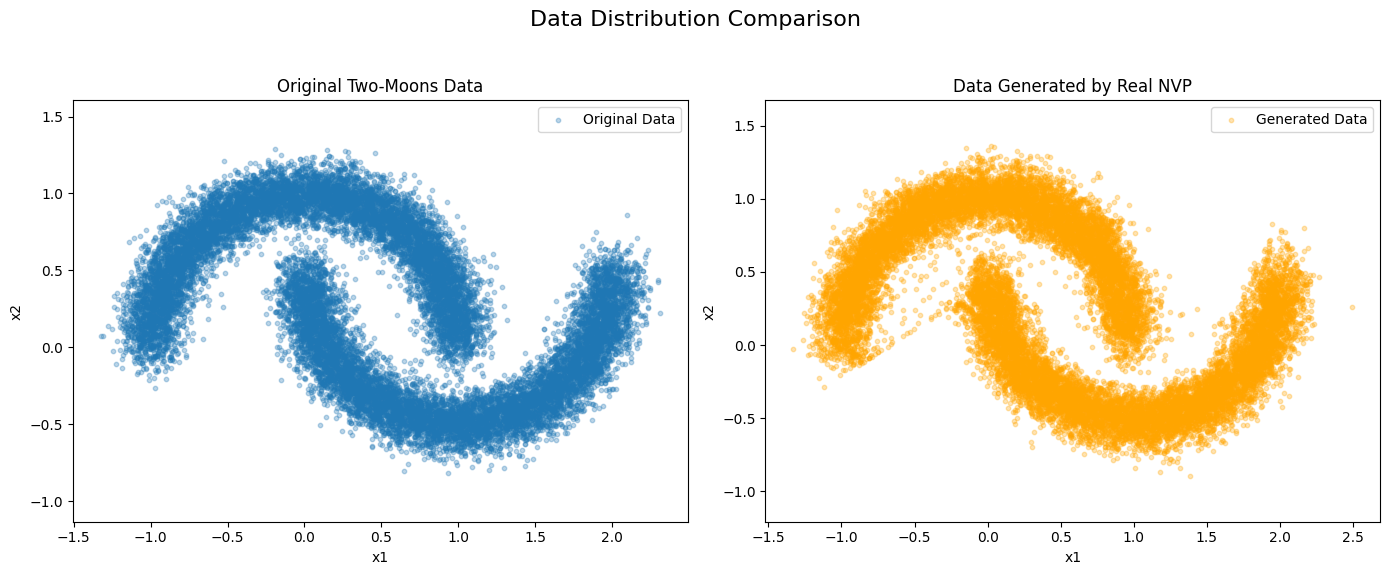

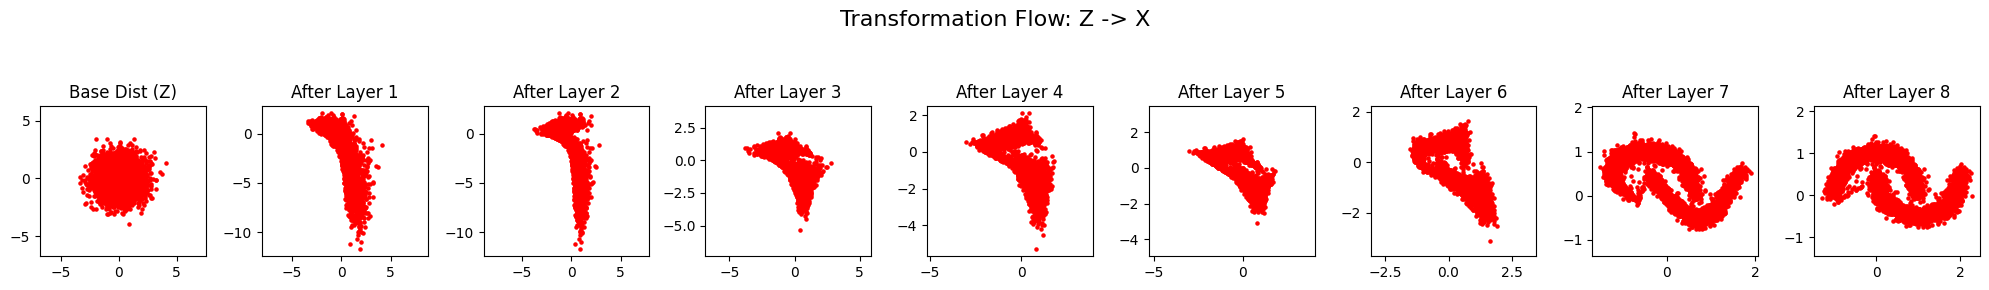

In [6]:
# --- 5. Visualization ---
model.eval()
with torch.no_grad():
    # a) Plot generated samples vs. original data
    plt.figure(figsize=(14, 6))
    
    # Original Data
    plt.subplot(1, 2, 1)
    plt.scatter(data.cpu()[:, 0], data.cpu()[:, 1], s=10, alpha=0.3, label='Original Data')
    plt.title('Original Two-Moons Data')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.axis('equal')

    # Generated Data
    plt.subplot(1, 2, 2)
    # Sample from base distribution
    z_samples = base_distribution.sample((n_samples,))
    # Transform to data space
    x_generated, _ = model.forward(z_samples)
    x_generated = x_generated.cpu().numpy()
    plt.scatter(x_generated[:, 0], x_generated[:, 1], s=10, alpha=0.3, c='orange', label='Generated Data')
    plt.title('Data Generated by Real NVP')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.axis('equal')
    
    plt.suptitle('Data Distribution Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # b) Recreate Figure 18.3: The "flow"
    fig, axes = plt.subplots(1, n_layers + 1, figsize=(20, 3))
    
    # Start with base distribution samples
    z_grid = base_distribution.sample((5000,))
    
    # Plot initial distribution
    axes[0].scatter(z_grid.cpu()[:, 0], z_grid.cpu()[:, 1], s=5, c='r')
    axes[0].set_title("Base Dist (Z)")
    axes[0].axis('equal')
    
    x_flow = z_grid
    for i, layer in enumerate(model.layers):
        x_flow, _ = layer.forward(x_flow)
        axes[i + 1].scatter(x_flow.cpu()[:, 0], x_flow.cpu()[:, 1], s=5, c='r')
        axes[i + 1].set_title(f"After Layer {i+1}")
        axes[i + 1].axis('equal')
        
    fig.suptitle('Transformation Flow: Z -> X', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.show()